In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
#import bambi as bmb
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
root = "../data/"
survDat = pd.concat([pd.read_csv(root + "cleanSurvBefore10s.csv"),
                     pd.read_csv(root + "cleanSurv10s.csv")],
                     ignore_index=True)

In [3]:
survDat.head()

,sitecode,sitename,year,weight,stratum,PSU,age,sex,grade,race4,...,qcigschool,qchewtobschool,qalcoholschool,qmarijuanaschool,qcurrentcocaine,qgenderexp,qtaughtHIV,qmusclestrength,qcurrentasthma,qtransgender
0,NYI,"Borough of Manhattan, NY (NYI)",2007,3.7107,49,2,5.0,1.0,2.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN
1,NYI,"Borough of Manhattan, NY (NYI)",2007,3.8955,49,2,5.0,1.0,4.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2,NYI,"Borough of Manhattan, NY (NYI)",2007,29.5199,14,2,5.0,1.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,NYI,"Borough of Manhattan, NY (NYI)",2007,29.5199,14,2,5.0,1.0,3.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
4,NYI,"Borough of Manhattan, NY (NYI)",2007,29.5199,14,2,5.0,1.0,3.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN


In [7]:
# These are the categories of the questions
carRiskqs = ["q8", "q9", "q10", "q11"]
violenceqs = ["q12", "q13", "q14", "q15",
              "q16", "q17", "q18"]
sexqs = ["q19", "q20", "q21", "q22", "q58", "q59",
         "q60", "q61", "q62", 
         "q63", "q64", "qtaughtHIV"]
bullyqs = ["q23", "q24", "qbullygay"]
suicideqs = ["q25", "q26", "q27", 
             "q28", "q29"]
drugqs = ["q30", "q32", "q33",
          "q38", "q40", "q41",
          "q45", "q46", "q47",
          "q50", "q51", "q52",
          "q53", "q54", "q55",
          "q56", "q57", "qcigschool",
          "qalcoholschool", "qmarijuanaschool",
          'q31', 'q34', 'q35',
          'q36', 'q37', 'q42', 
          'q43', 'q44', 'q48',
          'q49', "qchewtobschool",
          "qcurrentcocaine"]
selfqs = ["q65", "q66", "q67",
          "q68", "q89", "qnowt",
          "qnobese", "bmipct", "bmi",
          "sexpart", "sexpart2", "sexid",
          "sexid2", "stheight", "stweight",
          "race4", "race7", "sex",
          "age", "grade", "qgenderexp",
          "qmusclestrength", "qcurrentasthma",
          "qtransgender"] 
selfHealthqs = ["q69", "q70", "q71",
                "q72", "q73", "q74",
                "q76", "q79", "q81",
                "q82", "q87", 'q75',
                'q77', 'q78', 'q80',
                'q84', 'q86', 'q88'] # may want to move some of these to sexqs
riskqs = ["qbikehelmet", "qpropertydamage"]

listOfQList = [carRiskqs, violenceqs, sexqs,
               suicideqs, drugqs, selfqs,
               selfHealthqs, riskqs, bullyqs]
listOfQListName = ["carRiskqs", "violenceqs", "sexqs",
                   "suicideqs", "drugqs", "selfqs",
                   "selfHealthqs", "riskqs", "bullyqs"]

In [93]:
def clean_data(data, year, outcome_qs, input_qs, response_threshold ):
    new_data = data[data["year"] == year].copy()
    new_data["age"] = new_data["age"] + 12
    new_data = new_data[~new_data[outcome_qs].isna().all(axis=1)]

    all_qs = [x for l in input_qs for x in l]
    qs_response_rate = new_data[all_qs].isna().sum() / len(new_data)
    high_response_qs = np.where(qs_response_rate <= (1 - response_threshold))
    high_response_qs = qs_response_rate.index[high_response_qs]

    new_data = new_data.dropna(subset=high_response_qs)
    #print(carRiskScore(new_data).head())
    new_data["car_risk_score"] = carRiskScore(new_data)

    high_response_qs = np.setdiff1d(high_response_qs, outcome_qs)
    new_data = new_data[["car_risk_score"] + list(high_response_qs)]
    print(new_data.shape)
    
    return new_data

In [90]:
def carRiskScore(dat):
    carRiskqs = ["q8", "q9"]
    q8Scores = {1.0 : 8, 2.0 : 5, 3.0 : 3, 4.0 : 1, 5.0 : 0}
    q9Scores = {1.0 : 0, 2.0 : 3, 3.0 : 5, 4.0 : 7, 5.0 : 10}
    #q10Scores = {1.0 : 0, 2.0 : 0, 3.0 : 4, 4.0 : 6, 5.0 : 8, 6.0 : 10}
    #q11Scores = {1.0 : 0, 2.0 : 0, 3.0 : 2, 4.0 : 3, 5.0 : 5, 6.0 : 7, 7.0 : 8, 8.0 : 10}
    carRiskScores = {"q8" : q8Scores, "q9" : q9Scores,}
    saturatedScore = sum([max(carRiskScores[q].values()) for q in carRiskScores.keys()])
    
    return 1000*(dat[carRiskqs].apply(lambda col : col.replace(carRiskScores[col.name]))
                               .sum(axis=1)
                               .div(saturatedScore))

In [94]:
dat_2005 = clean_data(survDat, 2005, carRiskqs, listOfQList, .9)
dat_2007 = clean_data(survDat, 2007, carRiskqs, listOfQList, .9)
dat_2009 = clean_data(survDat, 2009, carRiskqs, listOfQList, .9)

(20595, 43)
(20811, 52)
(24173, 40)


In [95]:
dat_2005.head()

,car_risk_score,age,bmi,bmipct,grade,q12,q13,q15,q16,q17,...,qcigschool,qmarijuanaschool,qnobese,qnowt,qpropertydamage,race4,race7,sex,stheight,stweight
122833,166.666667,13.0,22.401235,89.512236,1.0,1.0,1.0,1.0,3.0,1.0,...,1.0,1.0,2.0,1.0,1.0,2.0,3.0,2.0,1.80,72.58
122834,0.000000,15.0,29.518950,97.827183,1.0,3.0,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.96,113.40
122836,222.222222,15.0,19.041156,43.184776,1.0,1.0,1.0,1.0,3.0,4.0,...,1.0,1.0,2.0,2.0,3.0,2.0,3.0,2.0,1.78,60.33
122839,333.333333,15.0,19.470395,49.891675,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,1.78,61.69
122840,0.000000,15.0,22.045828,78.873273,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,1.0,2.0,2.0,1.0,4.0,7.0,2.0,1.78,69.85


In [97]:
dat_2005.to_csv("../data/data_05.csv")
dat_2007.to_csv("../data/data_07.csv")
dat_2009.to_csv("../data/data_09.csv")


In [111]:
d = dat_2005.head(200)
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=1, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=2)
    x_coeff = pm.Normal("x", 0, sigma=2)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * d["q12"], sigma=sigma, observed=d["car_risk_score"])

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #trace = pm.sample(3000, return_inferencedata=True)

    #pm.sample_posterior_predictive(trace, var_names=["x"])

In [112]:
with model:
    trace = pm.sample(3000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


In [117]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"], samples=1000)

In [122]:
ppc["y"].shape

(12000, 200)

<AxesSubplot:xlabel='y / y'>

/home/aheldric/anaconda3/envs/stats507/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


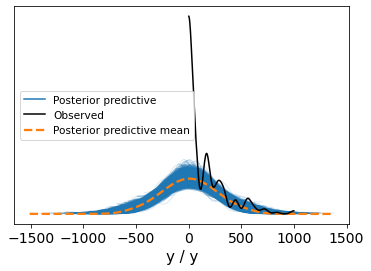

In [123]:
_ = az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

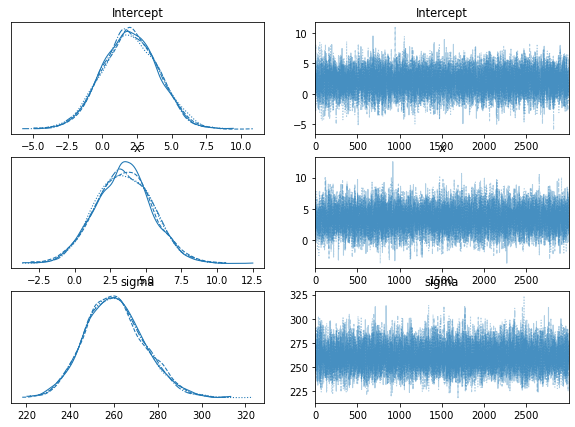

In [113]:
_ = az.plot_trace(trace, figsize=(10, 7))

TypeError: No model on context stack.